In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from dataclasses import dataclass
from pathlib import Path
import yaml

from omegaconf import OmegaConf, DictConfig
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.analysis.trf import trf_to_df
from src.encoding.ecog.timit import OutFile
from src.encoding.ecog import timit as timit_encoding, get_electrode_df, \
     AlignedECoGDataset, ContrastiveModelSnapshot, epoch_by_state_space

In [6]:
dataset = "timit"
subject = "EC212"
ttest_results_path = f"outputs/encoder_comparison_across_subjects/{dataset}/ttest.csv"
scores_path = f"outputs/encoder_comparison_across_subjects/{dataset}/scores.csv"
encoder_dirs = list(Path("outputs/encoders").glob(f"{dataset}/*/{subject}"))

pval_threshold = 1e-3

In [7]:
scores_df = pl.read_csv(scores_path).filter(
    pl.col("dataset") == dataset,
    pl.col("subject") == subject
)
scores_df

shape: (16_128, 10)
┌─────────┬─────────┬────────────┬──────────┬───┬────────────┬──────┬───────────┬────────────────┐
│ dataset ┆ subject ┆ model2     ┆ model1   ┆ … ┆ output_dim ┆ fold ┆ score     ┆ output_name    │
│ ---     ┆ ---     ┆ ---        ┆ ---      ┆   ┆ ---        ┆ ---  ┆ ---       ┆ ---            │
│ str     ┆ str     ┆ str        ┆ str      ┆   ┆ i64        ┆ i64  ┆ f64       ┆ str            │
╞═════════╪═════════╪════════════╪══════════╪═══╪════════════╪══════╪═══════════╪════════════════╡
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ 0          ┆ 0    ┆ 0.000318  ┆ (0, 'SG1')     │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ 0          ┆ 1    ┆ -0.000303 ┆ (0, 'SG1')     │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ 0          ┆ 2    ┆ 0.00178   ┆ (0, 'SG1')     │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ 1          ┆ 0    ┆ 0.003573  ┆ (1, 'SG2')     │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ 1          ┆ 1    ┆ 0.000343  ┆ (1, 'SG2')     │
│ …       ┆ …       ┆ …          ┆ …        ┆ … ┆ …          ┆ …    ┆ …         ┆ …              │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ 382        ┆ 1    ┆ -0.00248  ┆ (382, 'PG127') │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ 382        ┆ 2    ┆ -0.000503 ┆ (382, 'PG127') │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ 383        ┆ 0    ┆ -0.00343  ┆ (383, 'PG128') │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ 383        ┆ 1    ┆ -0.002097 ┆ (383, 'PG128') │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ 383        ┆ 2    ┆ -0.003099 ┆ (383, 'PG128') │
└─────────┴─────────┴────────────┴──────────┴───┴────────────┴──────┴───────────┴────────────────┘

In [8]:
ttest_df = pl.read_csv(ttest_results_path).filter(
    pl.col("dataset") == dataset,
    pl.col("subject") == subject
).with_columns(log_pval=pl.col("pval").log10())
ttest_df

shape: (1_050, 10)
┌─────────┬─────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ dataset ┆ subject ┆ model2     ┆ model1   ┆ … ┆ permutatio ┆ tval       ┆ pval       ┆ log_pval  │
│ ---     ┆ ---     ┆ ---        ┆ ---      ┆   ┆ n          ┆ ---        ┆ ---        ┆ ---       │
│ str     ┆ str     ┆ str        ┆ str      ┆   ┆ ---        ┆ f64        ┆ f64        ┆ f64       │
│         ┆         ┆            ┆          ┆   ┆ str        ┆            ┆            ┆           │
╞═════════╪═════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ shift      ┆ 1051.36720 ┆ 4.9106e-12 ┆ -11.30886 │
│         ┆         ┆            ┆          ┆   ┆            ┆ 9          ┆            ┆ 9         │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ shift      ┆ 318.343472 ┆ 5.8417e-10 ┆ -9.233461 │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ shift      ┆ 139.735324 ┆ 1.5732e-8  ┆ -7.803222 │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ shift      ┆ 95.16962   ┆ 7.3087e-8  ┆ -7.136162 │
│ timit   ┆ EC212   ┆ phoneme    ┆ baseline ┆ … ┆ shift      ┆ 82.908127  ┆ 1.2686e-7  ┆ -6.896658 │
│ …       ┆ …       ┆ …          ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …         │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ shift      ┆ 0.777269   ┆ 0.480406   ┆ -0.318392 │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ units      ┆ 0.773604   ┆ 0.482342   ┆ -0.316645 │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ shift      ┆ 0.17472    ┆ 0.869787   ┆ -0.060587 │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ shift      ┆ -0.14965   ┆ 0.888283   ┆ -0.051449 │
│ timit   ┆ EC212   ┆ word_broad ┆ baseline ┆ … ┆ shift      ┆ 0.024532   ┆ 0.981603   ┆ -0.008064 │
└─────────┴─────────┴────────────┴──────────┴───┴────────────┴────────────┴────────────┴───────────┘

In [9]:
# Ask whether minimum tval / maximum pval exceeds threshold
ttest_filtered_df = ttest_df.drop_nulls("tval").sort("tval", descending=False) \
    .group_by(["model2", "output_dim"]).first() \
    .filter(pl.col("pval") < pval_threshold)
ttest_filtered_df

shape: (157, 10)
┌────────────┬────────────┬─────────┬─────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ model2     ┆ output_dim ┆ dataset ┆ subject ┆ … ┆ permutatio ┆ tval      ┆ pval      ┆ log_pval  │
│ ---        ┆ ---        ┆ ---     ┆ ---     ┆   ┆ n          ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ i64        ┆ str     ┆ str     ┆   ┆ ---        ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆         ┆         ┆   ┆ str        ┆           ┆           ┆           │
╞════════════╪════════════╪═════════╪═════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ biphone_re ┆ 206        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 26.31422  ┆ 0.000012  ┆ -4.906781 │
│ con        ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
│ biphone_pr ┆ 232        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 13.237829 ┆ 0.000188  ┆ -3.72546  │
│ ed         ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
│ random8    ┆ 50         ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 9.088146  ┆ 0.000813  ┆ -3.090016 │
│ biphone_re ┆ 221        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 37.893895 ┆ 0.000003  ┆ -5.538139 │
│ con        ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
│ next_phone ┆ 215        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 26.826544 ┆ 0.000011  ┆ -4.94012  │
│ me         ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
│ …          ┆ …          ┆ …       ┆ …       ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ biphone_pr ┆ 200        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 56.67462  ┆ 5.8036e-7 ┆ -6.236304 │
│ ed         ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
│ phoneme    ┆ 112        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 11.443876 ┆ 0.000333  ┆ -3.477932 │
│ syllable   ┆ 189        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 12.209478 ┆ 0.000258  ┆ -3.587814 │
│ biphone_pr ┆ 201        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 574.34192 ┆ 5.5139e-1 ┆ -10.25854 │
│ ed         ┆            ┆         ┆         ┆   ┆            ┆ 8         ┆ 1         ┆           │
│ biphone_re ┆ 268        ┆ timit   ┆ EC212   ┆ … ┆ shift      ┆ 13.732132 ┆ 0.000163  ┆ -3.788001 │
│ con        ┆            ┆         ┆         ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴─────────┴─────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [10]:
encoder_dirs = [Path(p) for p in encoder_dirs]
encoders = {encoder_dir.parent.name: torch.load(encoder_dir / "model.pkl")
            for encoder_dir in encoder_dirs}
encoder_names = sorted(encoders.keys())

In [11]:
baseline_path = next(iter(path for path in encoder_dirs if "baseline" == path.parent.name))
baseline_scores = pl.read_csv(baseline_path / "scores.csv")
baseline_scores

shape: (1_152, 4)
┌──────┬────────────┬───────────┬────────────────┐
│ fold ┆ output_dim ┆ score     ┆ output_name    │
│ ---  ┆ ---        ┆ ---       ┆ ---            │
│ i64  ┆ i64        ┆ f64       ┆ str            │
╞══════╪════════════╪═══════════╪════════════════╡
│ 0    ┆ 0          ┆ 0.000318  ┆ (0, 'SG1')     │
│ 1    ┆ 0          ┆ -0.000303 ┆ (0, 'SG1')     │
│ 2    ┆ 0          ┆ 0.00178   ┆ (0, 'SG1')     │
│ 0    ┆ 1          ┆ 0.003573  ┆ (1, 'SG2')     │
│ 1    ┆ 1          ┆ 0.000343  ┆ (1, 'SG2')     │
│ …    ┆ …          ┆ …         ┆ …              │
│ 1    ┆ 382        ┆ -0.001886 ┆ (382, 'PG127') │
│ 2    ┆ 382        ┆ 0.00001   ┆ (382, 'PG127') │
│ 0    ┆ 383        ┆ -0.002824 ┆ (383, 'PG128') │
│ 1    ┆ 383        ┆ -0.00129  ┆ (383, 'PG128') │
│ 2    ┆ 383        ┆ -0.00143  ┆ (383, 'PG128') │
└──────┴────────────┴───────────┴────────────────┘

In [12]:
# Just need a random config in order to extract relevant paths and get outfile
sample_model_path = next(iter(path for path in encoder_dirs if "phoneme" == path.parent.name))
with (sample_model_path / ".hydra" / "config.yaml").open() as f:
    model_config = OmegaConf.create(yaml.safe_load(f))
out = timit_encoding.prepare_out_file(model_config, next(iter(model_config.data)))

In [13]:
snapshot = ContrastiveModelSnapshot.from_config(model_config, next(iter(model_config.feature_sets.model_features.values())))

In [14]:
aligned = AlignedECoGDataset(snapshot, out)

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

In [15]:
electrode_df = pl.read_csv(encoder_dirs[0] / "electrodes.csv")
electrode_df

shape: (464, 5)
┌───────────────┬────────────────┬───────────────┬───────┬─────────────────┐
│ electrode_idx ┆ electrode_name ┆ long_name     ┆ type  ┆ roi             │
│ ---           ┆ ---            ┆ ---           ┆ ---   ┆ ---             │
│ i64           ┆ str            ┆ str           ┆ str   ┆ str             │
╞═══════════════╪════════════════╪═══════════════╪═══════╪═════════════════╡
│ 0             ┆ SG1            ┆ SuperiorGrid1 ┆ grid  ┆ parsopercularis │
│ 1             ┆ SG2            ┆ SuperiorGrid2 ┆ grid  ┆ parsopercularis │
│ 2             ┆ SG3            ┆ SuperiorGrid3 ┆ grid  ┆ parsopercularis │
│ 3             ┆ SG4            ┆ SuperiorGrid4 ┆ grid  ┆ parsopercularis │
│ 4             ┆ SG5            ┆ SuperiorGrid5 ┆ grid  ┆ parsopercularis │
│ …             ┆ …              ┆ …             ┆ …     ┆ …               │
│ 459           ┆ EKG            ┆ EKG           ┆ EKG   ┆ []              │
│ 460           ┆ REF            ┆ Reference     ┆ strip ┆ []              │
│ 461           ┆ REF            ┆ Reference     ┆ strip ┆ []              │
│ 462           ┆ REF            ┆ Reference     ┆ strip ┆ []              │
│ 463           ┆ REF            ┆ Reference     ┆ strip ┆ []              │
└───────────────┴────────────────┴───────────────┴───────┴─────────────────┘

In [21]:
num_fit_electrodes = next(iter(encoders.values())).coef_.shape[0]
electrode_names = electrode_df.head(num_fit_electrodes).get_column("electrode_name").to_list()
coef_df = pl.concat([trf_to_df(encoder, electrode_names, return_pl=True).with_columns(model=pl.lit(model_name))
                     for model_name, encoder in tqdm(encoders.items())])
coef_df

  0%|          | 0/8 [00:00<?, ?it/s]

shape: (3_513_600, 8)
┌───────────────────┬─────────────┬───────────┬────────────┬─────┬──────┬───────────┬────────────┐
│ feature           ┆ output_name ┆ input_dim ┆ output_dim ┆ lag ┆ time ┆ coef      ┆ model      │
│ ---               ┆ ---         ┆ ---       ┆ ---        ┆ --- ┆ ---  ┆ ---       ┆ ---        │
│ str               ┆ str         ┆ i64       ┆ i64        ┆ i64 ┆ f64  ┆ f64       ┆ str        │
╞═══════════════════╪═════════════╪═══════════╪════════════╪═════╪══════╪═══════════╪════════════╡
│ onset             ┆ SG1         ┆ 0         ┆ 0          ┆ 0   ┆ 0.0  ┆ -0.000479 ┆ syllable   │
│ onset             ┆ SG1         ┆ 0         ┆ 0          ┆ 1   ┆ 0.01 ┆ -0.000616 ┆ syllable   │
│ onset             ┆ SG1         ┆ 0         ┆ 0          ┆ 2   ┆ 0.02 ┆ -0.000776 ┆ syllable   │
│ onset             ┆ SG1         ┆ 0         ┆ 0          ┆ 3   ┆ 0.03 ┆ -0.00075  ┆ syllable   │
│ onset             ┆ SG1         ┆ 0         ┆ 0          ┆ 4   ┆ 0.04 ┆ -0.000748 ┆ syllable   │
│ …                 ┆ …           ┆ …         ┆ …          ┆ …   ┆ …    ┆ …         ┆ …          │
│ model_embedding_7 ┆ PG128       ┆ 20        ┆ 383        ┆ 56  ┆ 0.56 ┆ 0.000216  ┆ word_broad │
│ model_embedding_7 ┆ PG128       ┆ 20        ┆ 383        ┆ 57  ┆ 0.57 ┆ -0.000178 ┆ word_broad │
│ model_embedding_7 ┆ PG128       ┆ 20        ┆ 383        ┆ 58  ┆ 0.58 ┆ -0.00039  ┆ word_broad │
│ model_embedding_7 ┆ PG128       ┆ 20        ┆ 383        ┆ 59  ┆ 0.59 ┆ -0.000664 ┆ word_broad │
│ model_embedding_7 ┆ PG128       ┆ 20        ┆ 383        ┆ 60  ┆ 0.6  ┆ -0.000636 ┆ word_broad │
└───────────────────┴─────────────┴───────────┴────────────┴─────┴──────┴───────────┴────────────┘

In [22]:
all_trf_features = sorted(coef_df.get_column("feature").unique().to_list())
all_trf_features

['F0',
 'formantMedOnset_0',
 'formantMedOnset_1',
 'formantMedOnset_2',
 'formantMedOnset_3',
 'maxDtL',
 'model_embedding_0',
 'model_embedding_1',
 'model_embedding_2',
 'model_embedding_3',
 'model_embedding_4',
 'model_embedding_5',
 'model_embedding_6',
 'model_embedding_7',
 'onset',
 'phnfeatConsOnset_0',
 'phnfeatConsOnset_1',
 'phnfeatConsOnset_2',
 'phnfeatConsOnset_3',
 'phnfeatConsOnset_4',
 'phnfeatConsOnset_5']

In [23]:
phonetic_features = [f"phnfeatConsOnset_{i}" for i in range(6)]
phonetic_features += [f"formantMedOnset_{i}" for i in range(4)]

### Compute epoched HGA

In [24]:
# hack together a new state space spec for sentence onset
# nb state space bounds are inclusive, so we need to subtract 1 from the end of each bound
trial_spec = StateSpaceAnalysisSpec(
    aligned.total_num_frames,
    ["trial"],
    [sorted([(start, end - 1) for start, end in aligned.name_to_frame_bounds.values()])],
)
aligned._snapshot.all_state_spaces["trial"] = trial_spec

In [26]:
trial_epochs = epoch_by_state_space(
    aligned, "trial",
    epoch_window=(-0.1, 1.),
    baseline_window=(-0.1, 0.),
    return_pl=True)
trial_epochs.head(3)

  0%|          | 0/580 [00:00<?, ?it/s]

shape: (3, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ epoch_idx ┆ electrode ┆ epoch_sam ┆ value     ┆ … ┆ item_star ┆ item_end_ ┆ epoch_dur ┆ epoch_ti │
│ ---       ┆ _idx      ┆ ple       ┆ ---       ┆   ┆ t_frame   ┆ frame     ┆ ation_sec ┆ me       │
│ i64       ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ s         ┆ ---      │
│           ┆ i64       ┆ i64       ┆           ┆   ┆ i64       ┆ i64       ┆ ---       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 0         ┆ 0         ┆ -0.000769 ┆ … ┆ 803496    ┆ 803586    ┆ 1.1       ┆ -0.1     │
│ 0         ┆ 1         ┆ 0         ┆ -1.896928 ┆ … ┆ 803496    ┆ 803586    ┆ 1.1       ┆ -0.1     │
│ 0         ┆ 2         ┆ 0         ┆ 0.998964  ┆ … ┆ 803496    ┆ 803586    ┆ 1.1       ┆ -0.1     │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Plotting prep

In [27]:
model_color_norm = plt.Normalize(0, len(encoder_names))
model_color_mapper = plt.colormaps["tab10"]
get_model_color = lambda model_name: model_color_mapper(model_color_norm(encoder_names.index(model_name)))

### Correspondences between electrodes significant under different models

In [28]:
log_pvals = ttest_filtered_df.pivot(values="log_pval", index="model2", columns="output_dim").fill_null(0.)
log_pvals

shape: (7, 74)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ model2    ┆ 206       ┆ 232       ┆ 50        ┆ … ┆ 291       ┆ 295       ┆ 112       ┆ 268      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ biphone_r ┆ -4.906781 ┆ -4.051796 ┆ 0.0       ┆ … ┆ -3.234167 ┆ 0.0       ┆ 0.0       ┆ -3.78800 │
│ econ      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
│ biphone_p ┆ -5.184407 ┆ -3.72546  ┆ 0.0       ┆ … ┆ 0.0       ┆ -3.138763 ┆ 0.0       ┆ 0.0      │
│ red       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ random8   ┆ 0.0       ┆ 0.0       ┆ -3.090016 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ next_phon ┆ 0.0       ┆ -3.042196 ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ eme       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ phoneme   ┆ -7.136162 ┆ -4.651275 ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ -3.477932 ┆ 0.0      │
│ word_broa ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ d         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ syllable  ┆ -3.42649  ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

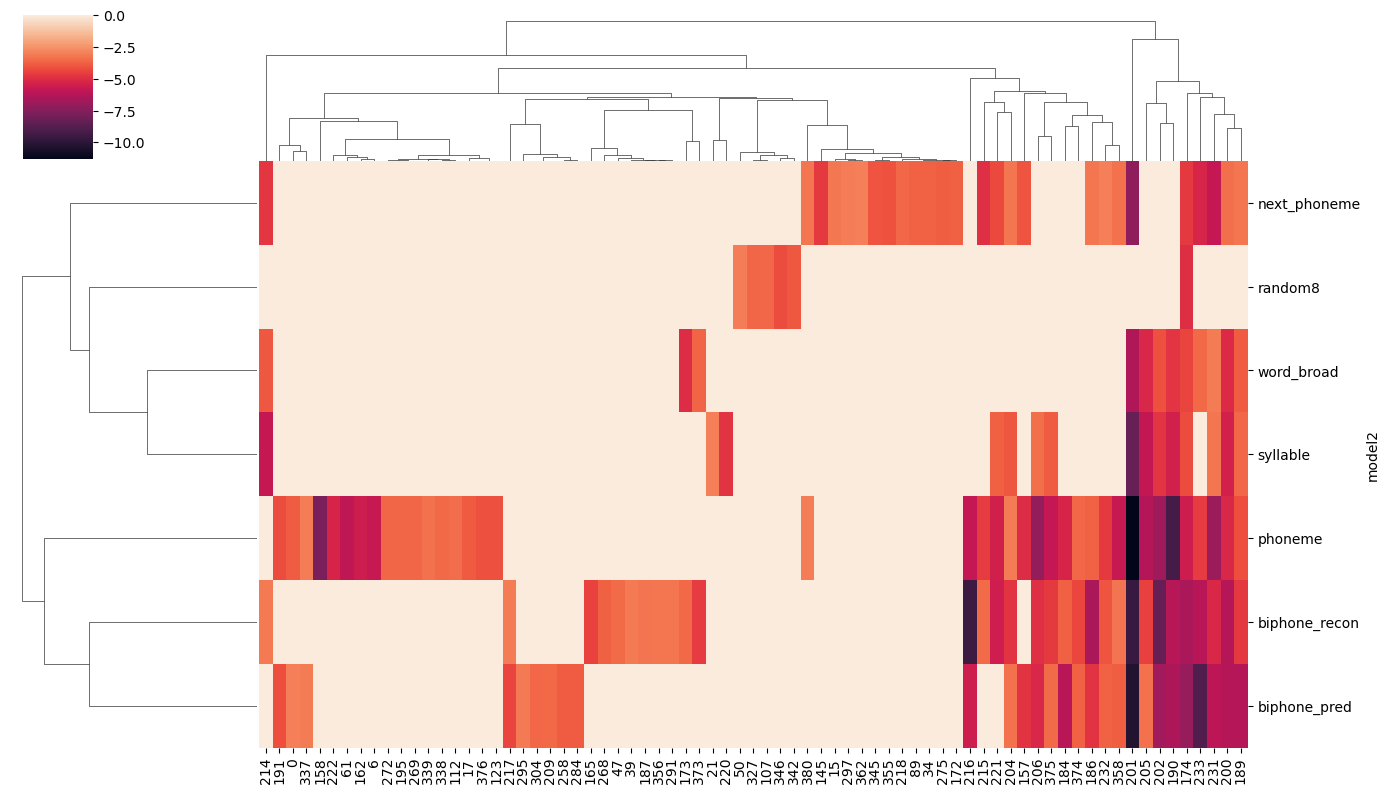

In [29]:
sns.clustermap(log_pvals.to_pandas().set_index("model2"),
               vmax=0, xticklabels=1, figsize=(14, 8))

## Colocation

### Colocation of baseline predictiveness and model improvement

In [30]:
score_relationship = scores_df.with_columns(model=pl.when(pl.col("model") == "baseline").then(pl.lit("baseline")).otherwise(pl.lit("full_model"))) \
    .pivot(index=["model2", "fold", "output_dim"], columns="model", values="score")
score_relationship

shape: (8_064, 5)
┌────────────┬──────┬────────────┬───────────┬────────────┐
│ model2     ┆ fold ┆ output_dim ┆ baseline  ┆ full_model │
│ ---        ┆ ---  ┆ ---        ┆ ---       ┆ ---        │
│ str        ┆ i64  ┆ i64        ┆ f64       ┆ f64        │
╞════════════╪══════╪════════════╪═══════════╪════════════╡
│ phoneme    ┆ 0    ┆ 0          ┆ 0.000318  ┆ 0.000553   │
│ phoneme    ┆ 1    ┆ 0          ┆ -0.000303 ┆ -0.000066  │
│ phoneme    ┆ 2    ┆ 0          ┆ 0.00178   ┆ 0.001973   │
│ phoneme    ┆ 0    ┆ 1          ┆ 0.003573  ┆ 0.003045   │
│ phoneme    ┆ 1    ┆ 1          ┆ 0.000343  ┆ 0.000208   │
│ …          ┆ …    ┆ …          ┆ …         ┆ …          │
│ word_broad ┆ 1    ┆ 382        ┆ -0.001886 ┆ -0.00248   │
│ word_broad ┆ 2    ┆ 382        ┆ 0.00001   ┆ -0.000503  │
│ word_broad ┆ 0    ┆ 383        ┆ -0.002824 ┆ -0.00343   │
│ word_broad ┆ 1    ┆ 383        ┆ -0.00129  ┆ -0.002097  │
│ word_broad ┆ 2    ┆ 383        ┆ -0.00143  ┆ -0.003099  │
└────────────┴──────┴────────────┴───────────┴────────────┘

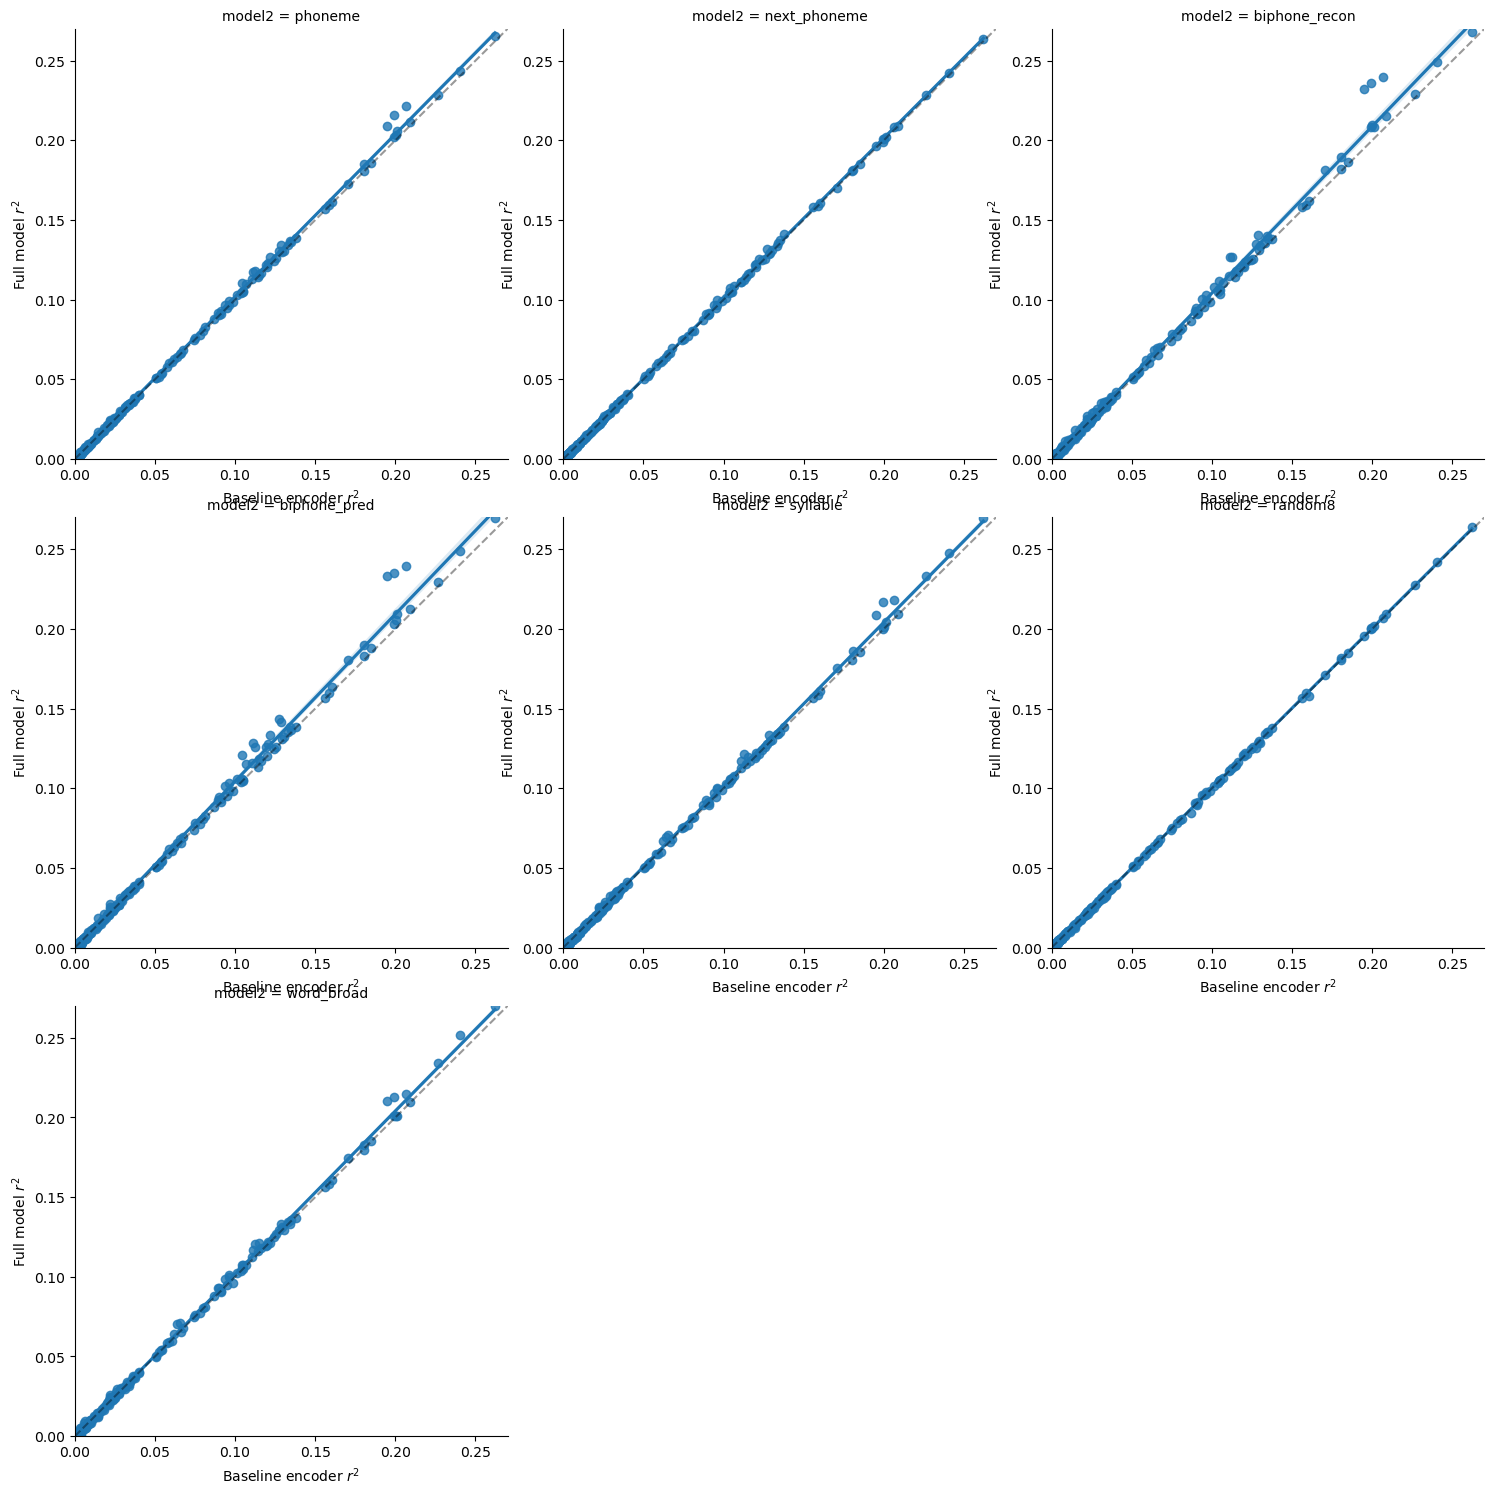

In [31]:
g = sns.lmplot(data=score_relationship.to_pandas(), x="baseline", y="full_model", col="model2", col_wrap=3,
               facet_kws=dict(sharex=False, sharey=False))

ax_min = 0.
ax_max = score_relationship.select(["baseline", "full_model"]).to_numpy().max().max()
for ax in g.axes.ravel():
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.4)
    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)
    ax.set_xlabel("Baseline encoder $r^2$")
    ax.set_ylabel("Full model $r^2$")

### Colocation of model embedding and TRF weights

Which electrodes demonstrate simultaneous activation in response to acoustic-phonetic weights and also model embeddings?

In [32]:
study_model = "syllable"
study_coef = coef_df.filter(pl.col("model") == "baseline") \
    .with_columns(base_feature=pl.col("feature").str.extract(r"(.+)_?"),
                  feature_is_phonetic=pl.col("feature").is_in(phonetic_features),
                  feature_is_prosodic=pl.col("feature").is_in(["F0", "maxDtL"]))

In [52]:
electrode_tvals = ttest_df.drop_nulls("tval").sort("tval", descending=False).group_by(["model2", "output_dim"]) \
    .first().select(["model2", "output_dim", "tval"])
feature_norms = study_coef.group_by(["base_feature", "output_dim"]).agg(
    pl.col("coef").pow(2).sum().sqrt().alias("feature_norm")
)
norm_study_df = electrode_tvals.join(feature_norms, on=["output_dim"], how="inner")
norm_study_df

shape: (6_825, 5)
┌───────────────┬────────────┬───────────┬────────────────────┬──────────────┐
│ model2        ┆ output_dim ┆ tval      ┆ base_feature       ┆ feature_norm │
│ ---           ┆ ---        ┆ ---       ┆ ---                ┆ ---          │
│ str           ┆ i64        ┆ f64       ┆ str                ┆ f64          │
╞═══════════════╪════════════╪═══════════╪════════════════════╪══════════════╡
│ word_broad    ┆ 35         ┆ 0.777269  ┆ phnfeatConsOnset_4 ┆ 0.005355     │
│ syllable      ┆ 245        ┆ 1.217377  ┆ formantMedOnset_1  ┆ 0.003368     │
│ next_phoneme  ┆ 245        ┆ 4.048552  ┆ formantMedOnset_1  ┆ 0.003368     │
│ next_phoneme  ┆ 92         ┆ 5.635305  ┆ F0                 ┆ 0.010548     │
│ syllable      ┆ 259        ┆ 7.583722  ┆ phnfeatConsOnset_5 ┆ 0.004804     │
│ …             ┆ …          ┆ …         ┆ …                  ┆ …            │
│ phoneme       ┆ 191        ┆ 17.794719 ┆ F0                 ┆ 0.02667      │
│ biphone_pred  ┆ 191        ┆ 17.294017 ┆ F0                 ┆ 0.02667      │
│ random8       ┆ 191        ┆ 0.169159  ┆ F0                 ┆ 0.02667      │
│ biphone_recon ┆ 191        ┆ 5.262775  ┆ F0                 ┆ 0.02667      │
│ syllable      ┆ 191        ┆ 4.022874  ┆ F0                 ┆ 0.02667      │
└───────────────┴────────────┴───────────┴────────────────────┴──────────────┘

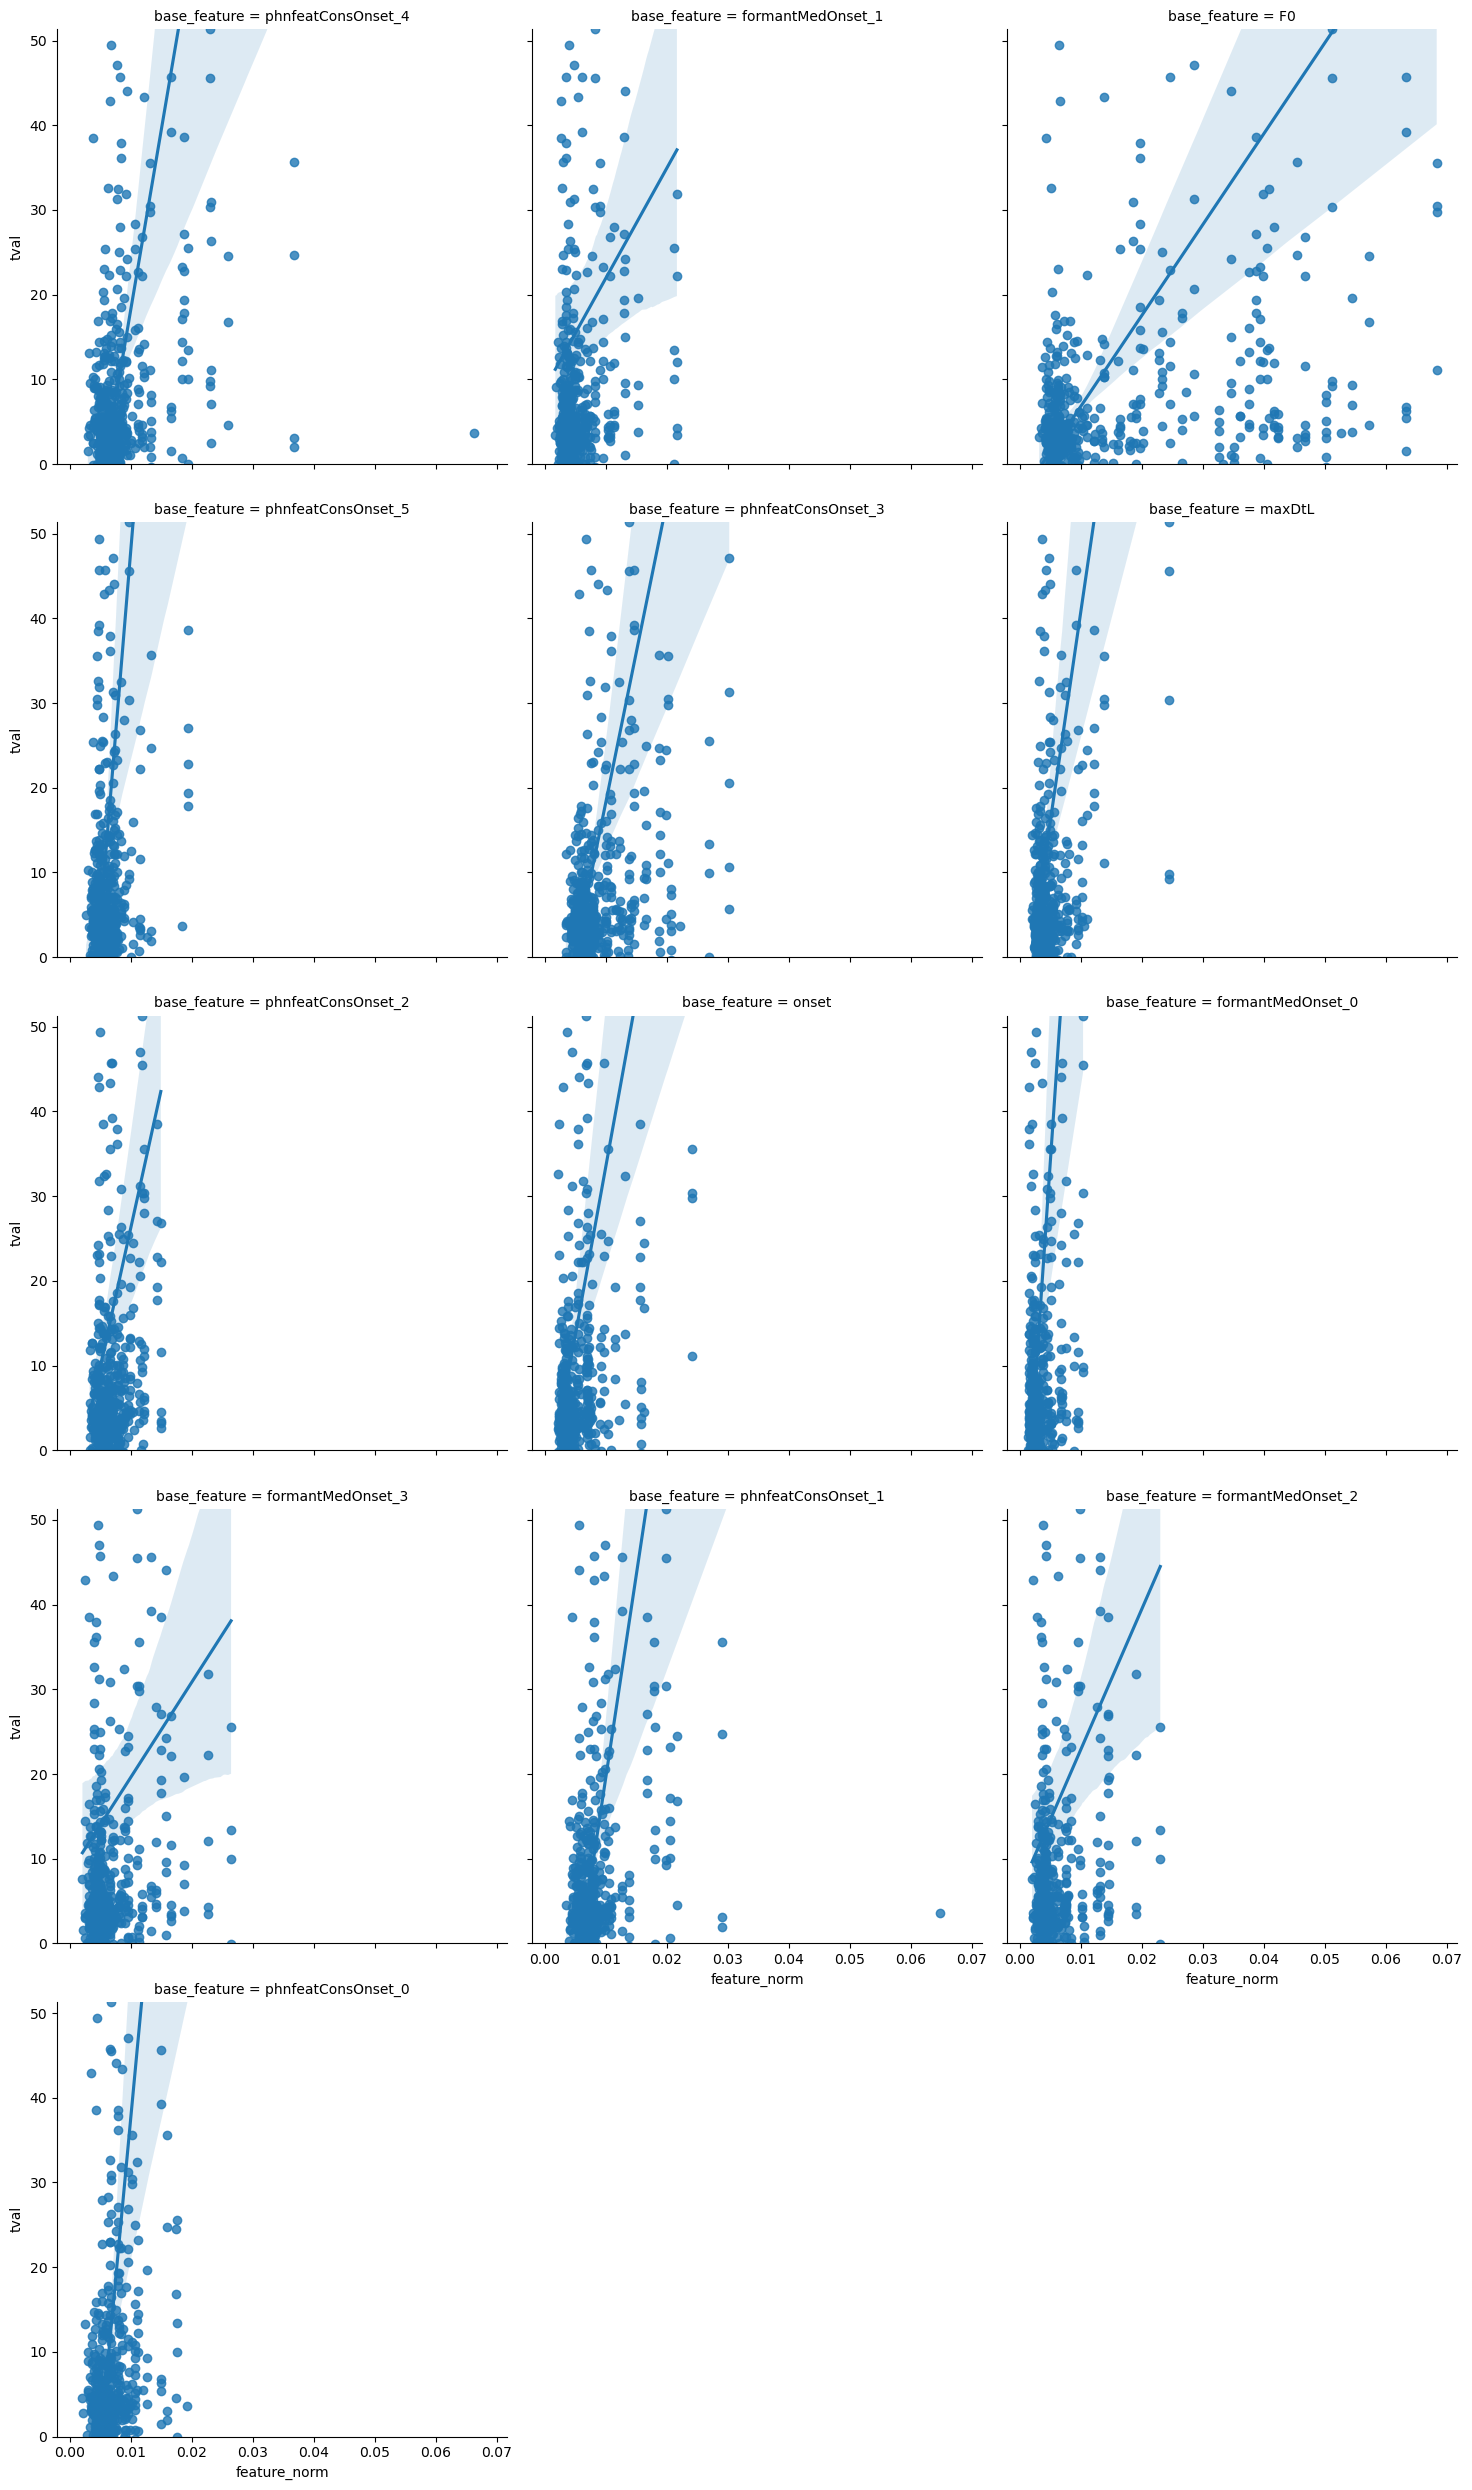

In [57]:
g = sns.lmplot(data=norm_study_df.to_pandas(),
               x="feature_norm", y="tval", col="base_feature", col_wrap=3)
# drop outliers
tval_max = np.percentile(norm_study_df.get_column("tval"), 95)
g.set(ylim=(0, tval_max))

In [122]:
feature_norms_phonetic = study_coef.groupby(["feature", "output_dim", "feature_is_phonetic"]).coef.apply(np.linalg.norm).to_frame("phonetic_norm").reset_index()
feature_norms_phonetic

feature  output_dim  feature_is_phonetic  phonetic_norm
0                     F0           0                False       0.008842
1                     F0           1                False       0.008650
2                     F0           2                False       0.006001
3                     F0           3                False       0.006489
4                     F0           4                False       0.005085
...                  ...         ...                  ...            ...
4987  phnfeatConsOnset_5         379                 True       0.006132
4988  phnfeatConsOnset_5         380                 True       0.003624
4989  phnfeatConsOnset_5         381                 True       0.004292
4990  phnfeatConsOnset_5         382                 True       0.005204
4991  phnfeatConsOnset_5         383                 True       0.005005

[4992 rows x 4 columns]

<Axes: xlabel='time', ylabel='coef'>

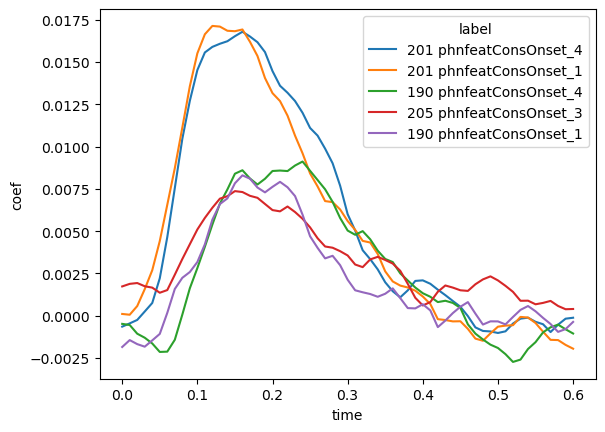

In [128]:
# Find largest-norm phonetic responses
plot_n = 5
max_norm_phonetic_responses = feature_norms_phonetic[feature_norms_phonetic.feature_is_phonetic == True].sort_values("phonetic_norm", ascending=False).set_index(["output_dim", "feature"]).head(plot_n).index
plot_df = study_coef.reset_index().set_index(["output_dim", "feature"]).loc[max_norm_phonetic_responses].reset_index()
plot_df["label"] = plot_df.output_dim.astype(str) + " " + plot_df.feature
sns.lineplot(data=plot_df, x="time", y="coef", hue="label")

### Colocation of model embedding and onset electrodes

In [171]:
# onset_epoch_measure = trial_epochs.groupby(["electrode_idx", "epoch_time"]).value.mean().reset_index() \
#     .groupby("electrode_idx").apply(lambda xs: np.linalg.norm(xs[xs.epoch_time.between(0.15, 0.5)].value)
#                                                 - np.linalg.norm(xs[xs.epoch_time > 0.5].value)) \
#     .rename("onset_epoch_measure") \
#     .sort_values(ascending=False)

In [156]:
onset_coef_measure = study_coef[study_coef.feature == "onset"].groupby("output_dim") \
    .apply(lambda xs: np.linalg.norm(xs[xs.time.between(0.15, 0.5)].coef) - np.linalg.norm(xs[xs.time > 0.5].coef)) \
    .rename("onset_coef_measure") \
    .sort_values(ascending=False)

/tmp/ipykernel_989236/2070558725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)


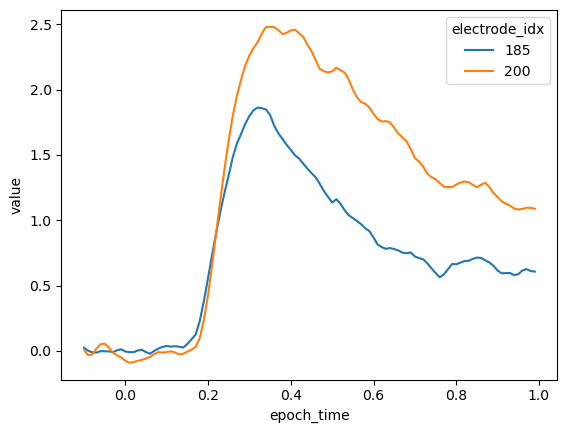

In [191]:
norm_threshold = 0.008
plot_epochs = trial_epochs[trial_epochs.electrode_idx.isin(onset_coef_measure[onset_coef_measure > norm_threshold].index)]
plot_epochs["electrode_idx"] = plot_epochs.electrode_idx.astype(str)
if len(plot_epochs) > 0:
    sns.lineplot(data=plot_epochs,
                x="epoch_time", y="value", hue="electrode_idx", errorbar=None)

In [183]:
onset_coef_tvals = pd.merge(electrode_tvals, onset_coef_measure, left_index=True, right_index=True, validate="many_to_one")
onset_coef_tvals

tval  onset_coef_measure
model2       output_dim                               
biphone_pred 0            8.794796           -0.000177
             8            4.620742            0.000324
             13           4.631548            0.001428
             17           3.636175            0.002247
             47           7.168423           -0.000558
...                            ...                 ...
word_broad   365          1.829890            0.002835
             369          2.789894            0.001288
             373         12.877002            0.001790
             374          8.362405            0.003802
             375          2.463045            0.006051

[525 rows x 2 columns]

In [187]:
embedding_coef_norms = coef_df[coef_df.feature.str.startswith("model_embedding")] \
    .groupby(["model", "output_dim", "feature"]).coef.apply(np.linalg.norm) \
    .groupby(["model", "output_dim"]).mean().rename("model_coef_norm")
onset_embedding_coef_norms = pd.merge(
    onset_coef_measure, embedding_coef_norms, left_index=True, right_index=True)
onset_embedding_coef_norms

onset_coef_measure  model_coef_norm
model        output_dim                                     
biphone_pred 0                    -0.000177         0.004765
             1                     0.002491         0.004052
             2                     0.001435         0.003892
             3                     0.000205         0.003821
             4                     0.001067         0.003661
...                                     ...              ...
word_broad   379                   0.000936         0.002522
             380                   0.000752         0.002754
             381                   0.001932         0.003202
             382                   0.001581         0.002902
             383                   0.001379         0.002572

[2688 rows x 2 columns]

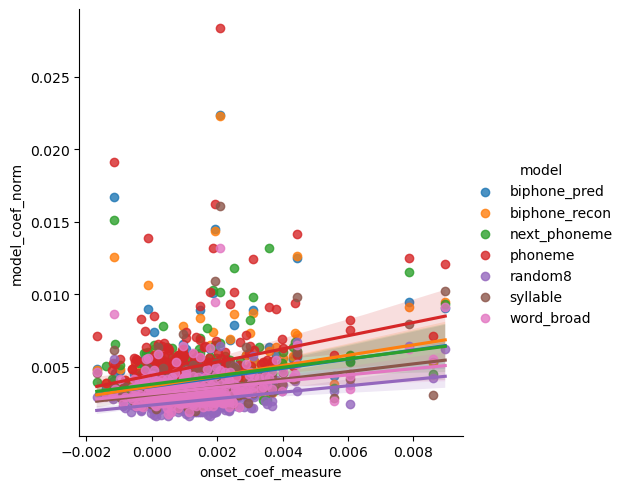

In [188]:
sns.lmplot(data=onset_embedding_coef_norms.reset_index(),
                x="onset_coef_measure", y="model_coef_norm", hue="model",
                )

In [189]:
onset_emb_correlations = onset_embedding_coef_norms \
    .groupby("model").apply(lambda df: pd.Series(spearmanr(df.onset_coef_measure, df.model_coef_norm), index=["rho", "pval"])) \
    .sort_values("rho")
onset_emb_correlations

rho      pval
model                            
word_broad     0.108169  0.034093
syllable       0.115022  0.024190
next_phoneme   0.122274  0.016518
biphone_pred   0.150748  0.003063
biphone_recon  0.150775  0.003058
random8        0.158925  0.001784
phoneme        0.170921  0.000770

## ERPs for top-explained electrodes

In [150]:
def plot_epochs(epochs_df, facet_kwargs=None):
    # Order columns by peak mean value
    col_order = epochs_df.groupby(["electrode_idx", "epoch_sample"]) \
        .value.mean().abs().groupby("electrode_idx").max() \
        .sort_values(ascending=False).index
    g = sns.relplot(data=epochs_df,
                    x="epoch_time", y="value", col="electrode_idx",
                    col_wrap=3, col_order=col_order, kind="line",
                    facet_kws={"sharex": False}, **(facet_kwargs or {}))

    # standard y-position for each model
    model_rect_size = 0.05
    get_model_position = lambda model_name: 0.1 + model_rect_size * sorted(encoder_names).index(model_name)

    for ax, electrode_idx in zip(g.axes.ravel(), col_order):
        ax.axvline(0, color="gray", linestyle="--")
        ax.axhline(0, color="gray", linestyle="--")

        # which models show significant prediction of this electrode?
        for model_name, log_pval_i in log_pvals[electrode_idx].items():
            alpha = 0.05 if log_pval_i == 0 else 0.8
            rect = plt.Rectangle((0.05, get_model_position(model_name)), model_rect_size, model_rect_size,
                                  color=get_model_color(model_name), alpha=alpha, transform=ax.transAxes)
            
            if log_pval_i != 0:
                # annotate with score
                ax.text(0.12, get_model_position(model_name), f"{np.power(10, log_pval_i):.1g}",
                        verticalalignment="bottom", alpha=0.8,
                        transform=ax.transAxes)
            ax.add_patch(rect)
            
    # add a model legend above the top of the facet grid
    legend_ax = g.fig.add_axes([0.1, 1.0, 0.8, 0.05])
    legend_ax.axis("off")
    for model_name in encoder_names:
        legend_ax.add_patch(plt.Rectangle((0.75 * model_rect_size, get_model_position(model_name)), model_rect_size, model_rect_size,
                                        color=get_model_color(model_name), alpha=0.8, transform=legend_ax.transAxes))
        legend_ax.text(0.1, get_model_position(model_name), model_name, verticalalignment="bottom",
                    transform=legend_ax.transAxes)
        
    return g

### Trial onset ERP for top-explained electrodes

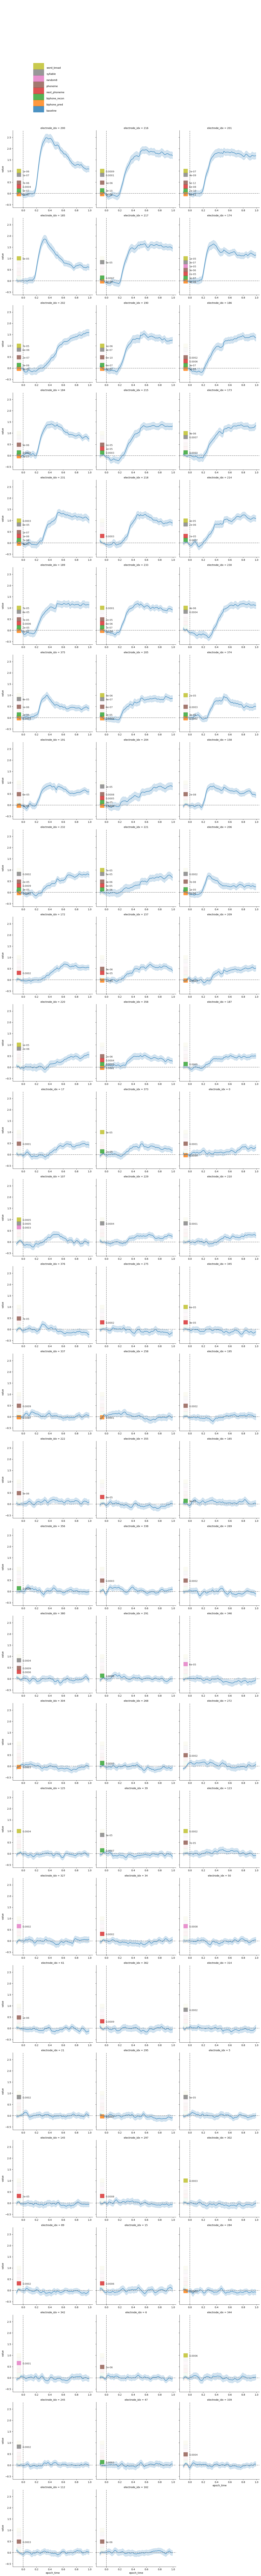

In [151]:
plot_epoch_electrodes = ttest_filtered_df.index.get_level_values("output_dim").unique()
plot_trial_epochs = trial_epochs[trial_epochs.electrode_idx.isin(plot_epoch_electrodes)]
plot_epochs(plot_trial_epochs)

### Word onset ERP for top-explained electrodes

In [152]:
word_epochs = epoch_by_state_space(
    aligned, "word",
    subset_electrodes=plot_epoch_electrodes,
    epoch_window=(-0.1, 0.3),
    baseline_window=(-0.1, 0.),
    return_df=True)

  0%|          | 0/3052 [00:00<?, ?it/s]

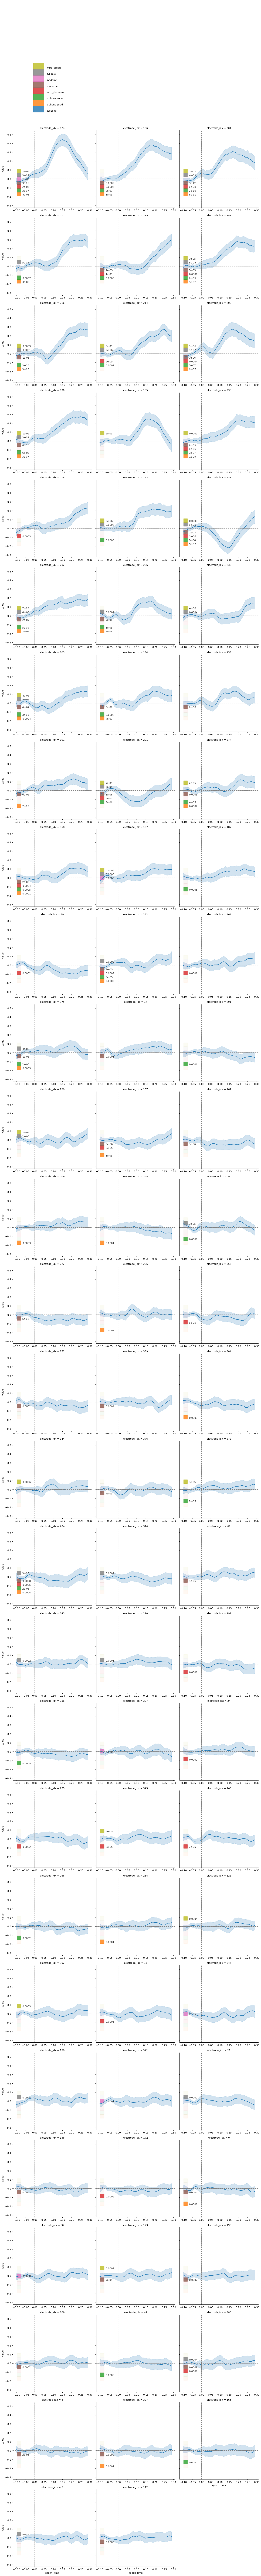

In [153]:
plot_epochs(word_epochs)

## Coefficients for top-explained electrodes